# PGAM Tuorial

The tutorial will cover the main components of the model, in particular:

1. **B-spline**: create and plot the approapriae basis set for different tpye of response funcions: 1D and 2D responses, cyclic or not, and temporal kernels.

2. **Define the B-spline via the *smooths_handler* class**: format the model covariates and set the parameters required to desine the B-spline via the *smooths_handler* class

3. **Smoothing enforcing** regularization

4. **Model fit**: fit the model, plot and explore the output

5. **Standard input & configuration files.** Fit the model using standard configuration file and input files.

In [4]:
# Import libraries

## if working outside the docker contaiener, uncomment below and add the path to the folder PGAM/GAM_library 

import sys
sys.path.append('src/')

import numpy as np
import sys
from PGAM.GAM_library import *
import PGAM.gam_data_handlers as gdh
import matplotlib.pylab as plt
import pandas as pd
from post_processing import postprocess_results

path None do not exist
user not uses cuda
Module pycuda not found! Use CPU
path None do not exist
Module pycuda not found! Use CPU


# 1. B-spline design
B-spline of order $n+1$ is a basis set of picewise polynomials of degree $n$. The basis is define recursively, see https://en.wikipedia.org/wiki/B-spline, by specifying the set of knots where the polynomial pieces meet.  When the knots are distinct, the first $n − 2$ derivatives of the polynomial pieces are continuous at each knot.

It is imporant to distinguish between internal knots (that cover the domain of the variable of interest) and end-points. Since, by definition, each B-spline has support over $n+1$ knots, it follows that in order to fully cover the domain of interest one needs to extend the internal knots $n-1$ end-points at each side of the domain.

The most common choice is to simplpy repeat the first and last knot $n-1$ times.

Cyclical B-spline can be defined to describe responses to cyclical input variables (angles); since there are no borders for cyclic variables, the specification of the internal knots fully characterizes the cyclical B-spline.

If the domain is correcty specified, the sum of the B-splines over internal points should equal to one.



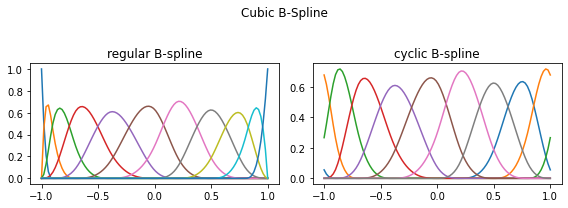

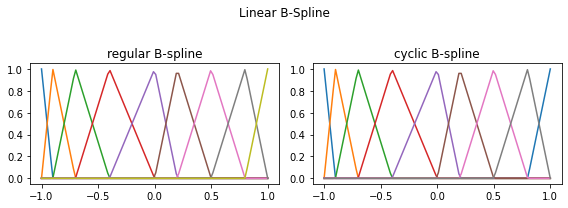

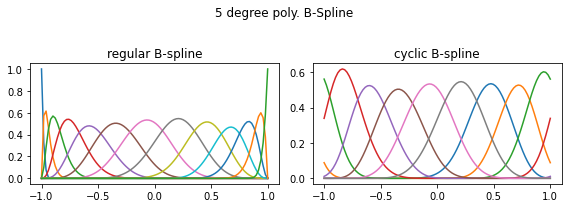

In [2]:
# Cubic B-spline covering [-1,1]

# Input
x = np.linspace(-1, 1, 100)
order = 4 # the order of the spline is the number of coefficient of the polynomials

# specify some internal knots
int_knots = np.array([-1., -.9, -0.7, -.4, 0, .2, .5, .8, 1.0])

# repeat external knots
knots = np.hstack(([int_knots[0]]*(order-1), int_knots, [int_knots[-1]]*(order-1)))

# get the spline basis evaluated at x for the domain
X = gdh.splineDesign(knots, x, order, der=0)

# get the cyclical b-spline over the same domain 
# (for cyclic spline basis, knots repetition is not required)
cX = gdh.cSplineDes(int_knots, x, order, der=0)

# plot the basis
plt.figure(figsize=(8,3))
plt.suptitle('Cubic B-Spline')

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

x_rep = np.repeat(x, X.shape[1]).reshape(x.shape[0],-1)
p1 = ax1.plot(x_rep,X)

ax1.set_title('regular B-spline')

x_rep = np.repeat(x, cX.shape[1]).reshape(x.shape[0],-1)
ax2.set_title('cyclic B-spline')
p2 = ax2.plot(x_rep,cX)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Assert that the B-spline convers the input range
assert(all(np.abs(X.sum(axis=1) - 1) < 10**-12))
assert(all(np.abs(cX.sum(axis=1) - 1) < 10**-12))


## Linear B-spline
order = 2
knots = np.hstack(([int_knots[0]]*(order-1), int_knots, [int_knots[-1]]*(order-1)))

# get the spline basis evaluated at x for the domain
X = gdh.splineDesign(knots, x, order, der=0)

# get the cyclical b-spline over the same domain 
# (for cyclic spline basis, knots repetition is not required)
cX = gdh.cSplineDes(int_knots, x, order, der=0)

# plot the basis
plt.figure(figsize=(8,3))
plt.suptitle('Linear B-Spline')

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

x_rep = np.repeat(x, X.shape[1]).reshape(x.shape[0],-1)
p1 = ax1.plot(x_rep,X)
ax1.set_title('regular B-spline')

x_rep = np.repeat(x, cX.shape[1]).reshape(x.shape[0],-1)
ax2.set_title('cyclic B-spline')
p2 = ax2.plot(x_rep,cX)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


## 5-degree B-spline
order = 6
knots = np.hstack(([int_knots[0]]*(order-1), int_knots, [int_knots[-1]]*(order-1)))

# get the spline basis evaluated at x for the domain
X = gdh.splineDesign(knots, x, order, der=0, outer_ok=True)

# get the cyclical b-spline over the same domain 
# (for cyclic spline basis, knots repetition is not required)
cX = gdh.cSplineDes(int_knots, x, order, der=0)

# plot the basis
plt.figure(figsize=(8,3))
plt.suptitle('5 degree poly. B-Spline')

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

x_rep = np.repeat(x, X.shape[1]).reshape(x.shape[0],-1)
p1 = ax1.plot(x_rep,X)
ax1.set_title('regular B-spline')

x_rep = np.repeat(x, cX.shape[1]).reshape(x.shape[0],-1)
ax2.set_title('cyclic B-spline')
p2 = ax2.plot(x_rep,cX)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

## 1.1 Higer dimensional B-spline

It is possible to define a basis for multidimensinoal response funciton as a tensor product of uni-dimensional basis. For example, a 2D response funciton could be expanded as $f(x,y) \approx \sum_{ij} \alpha_i \beta_j a_i(x)b_j(y)$, where $\{a_1, \dots, a_n\}$  and $\{b_1, \dots, b_m\}$ are B-splines over the domain of $x$ and $y$ rispectively.

<IPython.core.display.Javascript object>


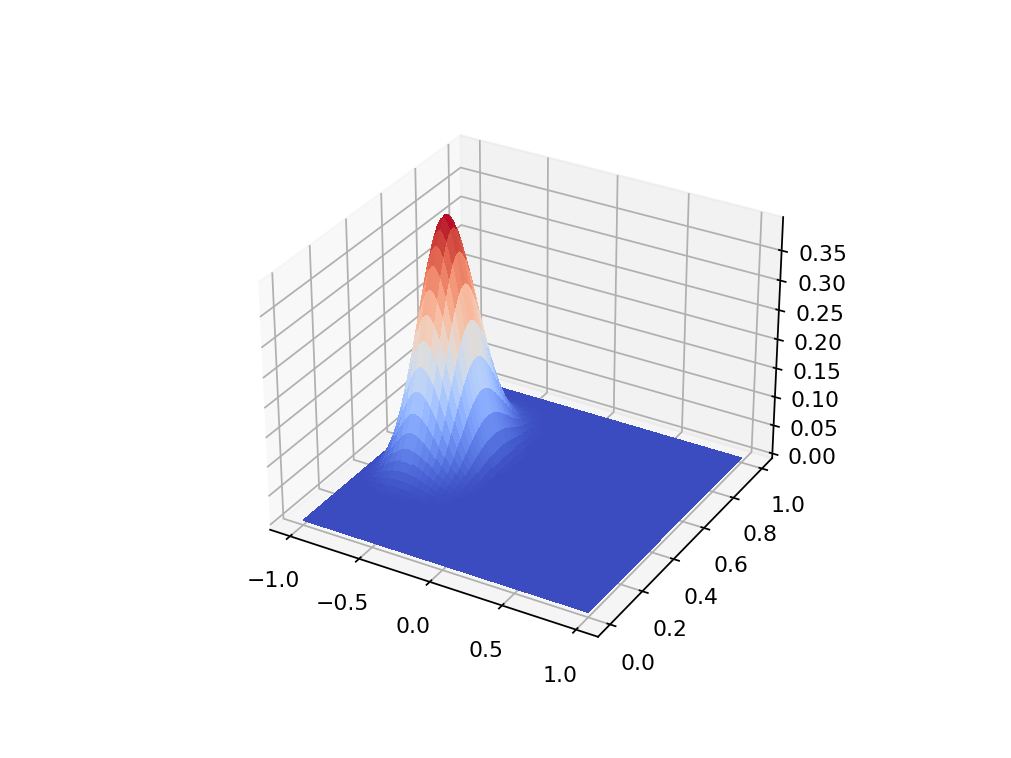

In [3]:
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook
# 2D basis set for product of cubic interpolaties
order = 4
int_knots_x = np.linspace(-1,1,8)
int_knots_y = np.linspace(0,1,6)
knots_x = np.hstack(([int_knots_x[0]]*(order-1), int_knots_x, [int_knots_x[-1]]*(order-1)))
knots_y = np.hstack(([int_knots_y[0]]*(order-1), int_knots_y, [int_knots_y[-1]]*(order-1)))



# input variables
x = np.linspace(-1,1,100)
y = np.linspace(0,1,100)
x_mesh, y_mesh = np.meshgrid(x,y)
X = gdh.splineDesign(knots_x, x_mesh.flatten(), order, der=0)
Y = gdh.splineDesign(knots_y, y_mesh.flatten(), order, der=0)

# product basis
XY = multiRowWiseKron(X,Y, sparseX=False)

# plot a bais element
i = 20
bi = XY[:,i]
bi = bi.reshape(x_mesh.shape)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x_mesh, y_mesh, bi, cmap=plt.get_cmap('coolwarm'),
                       linewidth=0, antialiased=False)


# 2. Input data format and the *smooths_handler* class

The *smooths_handler* class will constrict the appropriate B-spline for all the covariates of interest. In otder to be inpued to the *smooths_handler* object, covariates to be stacked in a single vector. Trial ids needs to be passed to the *smooths_handler* as a vector of the same length of the covariate vector. 

We label the covariates as "temporal" or "spatial" in order to specify two different type of response functions:  

1. The response to a **temporal variable** is assumed to be the convolution of a kernel function (described in terms of B-spline) and the variable:

    \begin{align}
    f(x_t) &= \int_{-\infty}^{\infty} x(\tau) h(t-\tau) d \tau \\
    h(t) &= \sum_j \beta_j b_j(t)
    \end{align}

    where $b_j$ are spline basis elements.


2. Response to **spatial variable** are instantaneous non-linear effects,
    \begin{align}
    f(x_t) = \sum_j\beta_j b_j(x_t).
    \end{align}

Fitting a PGAM will entail learning the appropriate $\mathbf{\beta}$ coefficients characterizing the response function.

Below we will create an example of three syntetic covariates (an event indicator, a 1D continous variable and a 2D continuous variable) for an experiment with 2 trials of 500 time points per trial.

## 2.1 Temporal covariates

Below we specify an acausal and the two directional filters

<IPython.core.display.Javascript object>


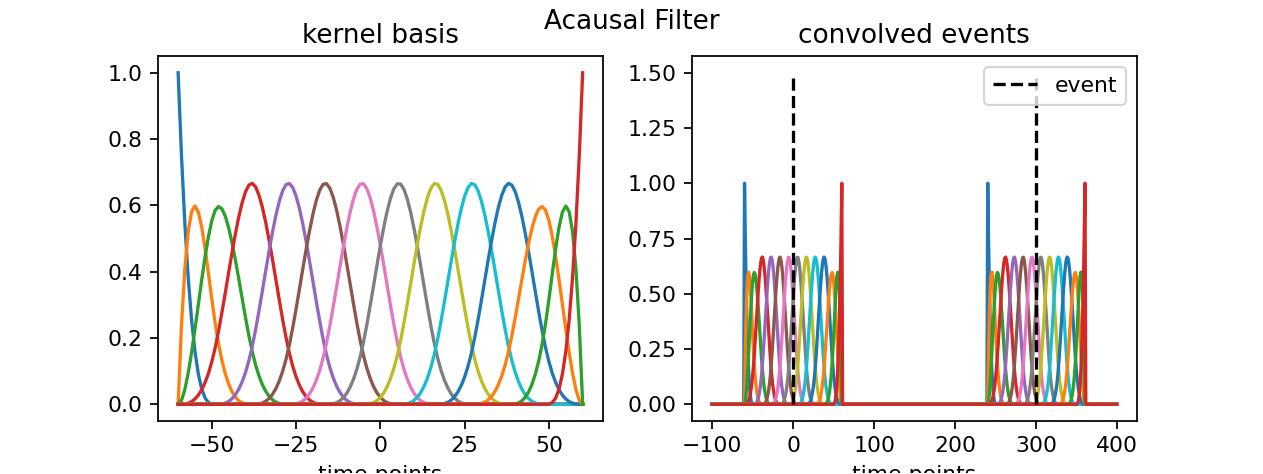

<IPython.core.display.Javascript object>


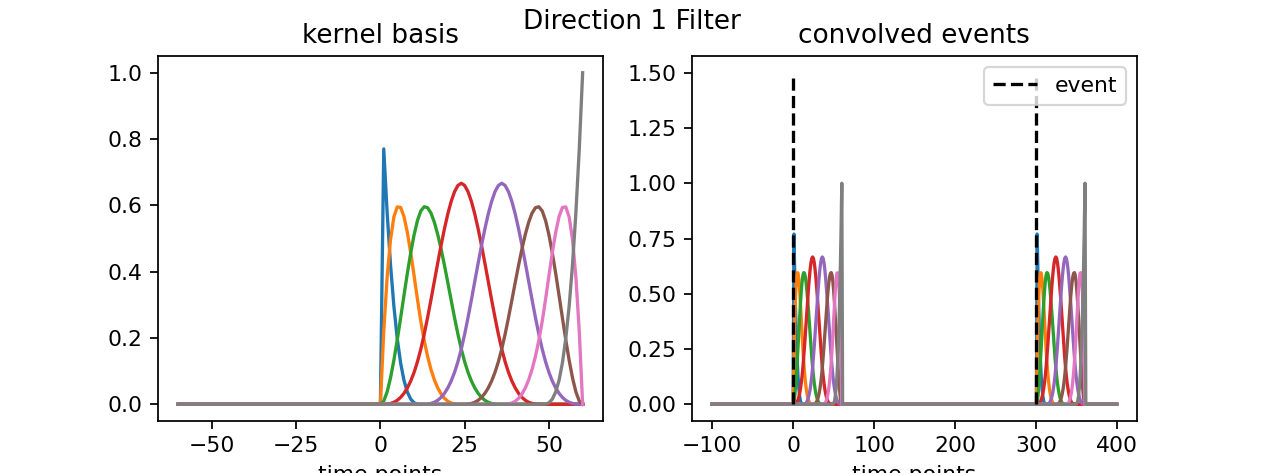

<IPython.core.display.Javascript object>


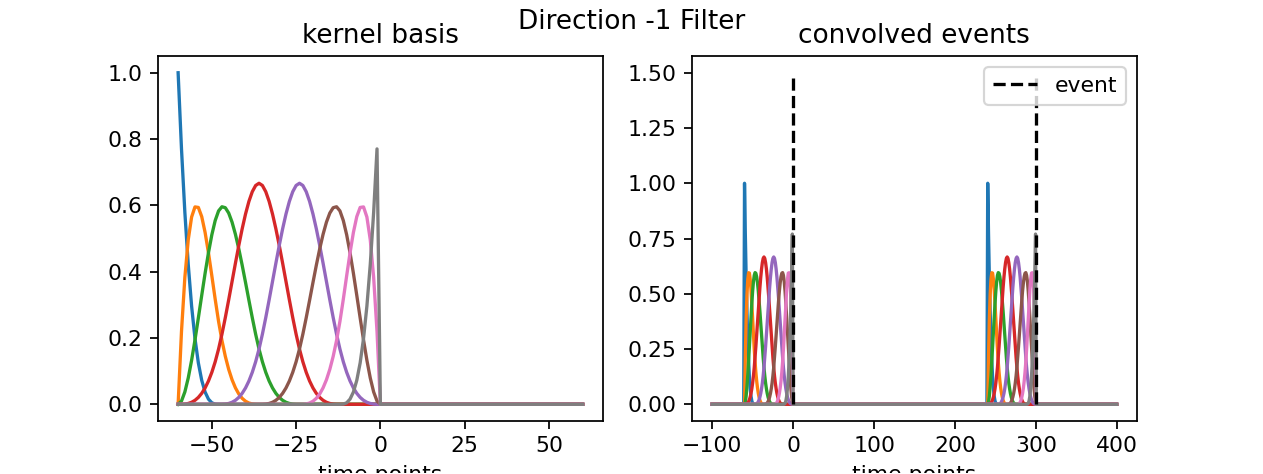

In [4]:

# Define a series of event marker
tot_tp = 10**3

# set some trial ids
trial_ids = np.zeros(tot_tp)
trial_ids[400:] = 1

# sample some event marker at random
event = np.zeros(tot_tp)
event[[100, 200, 600, 900]] = 1

# define the b-spline params
kernel_h_legnth = 121 # duration of the kernel h(t) in time points 
num_int_knots = 12 # number of internal knots used to represent h
order = 4
dict_kernel = {0:'Acausal',1:'Direction %d'%1, -1:'Direction %d'%(-1)}


for kernel_direction in [0,1,-1]:
    # define the "smooths_handler" container
    sm_handler = gdh.smooths_handler()
    
    # add the covariate & evaluate the convolution
    sm_handler.add_smooth('this_event', [event], is_temporal_kernel=True, ord=order, knots_num=num_int_knots,
                          trial_idx=trial_ids,kernel_length=kernel_h_legnth,kernel_direction=kernel_direction)

    # sm_handler['varname'] process and stores the covarie
    convolved_ev = sm_handler['this_event'].X.toarray()
    basis = sm_handler['this_event'].basis_kernel.toarray()

    plt.figure(figsize=(8,3))
    plt.suptitle('%s Filter'%dict_kernel[kernel_direction])
    # basis for the kenel h
    plt.subplot(121)
    plt.title('kernel basis')
    tps = np.repeat(np.arange(kernel_h_legnth)-kernel_h_legnth//2, basis.shape[1]).reshape(basis.shape)
    plt.plot(tps, basis)
    plt.xlabel('time points')

    plt.subplot(122)
    plt.title('convolved events')

    # select a time point interval containing an event
    idx0, idx1 = np.where(event == 1)[0][2] - 100, np.where(event == 1)[0][2] + 400

    # extract the events convolved with each of the B-spline elements
    conv = convolved_ev[idx0:idx1,:]

    tps = np.arange(0,idx1-idx0) - 100
    tps = np.repeat(tps,conv.shape[1]).reshape(conv.shape)
    plt.plot(tps, conv)
    plt.vlines(tps[0,0] + np.where(event[idx0:idx1])[0],0,1.5,'k',ls='--',label='event')
    plt.xlabel('time points')
    plt.legend()



## 2.2 Spatial variable 1D and 2D

Add the variable to the previously define smooths handler.

<IPython.core.display.Javascript object>


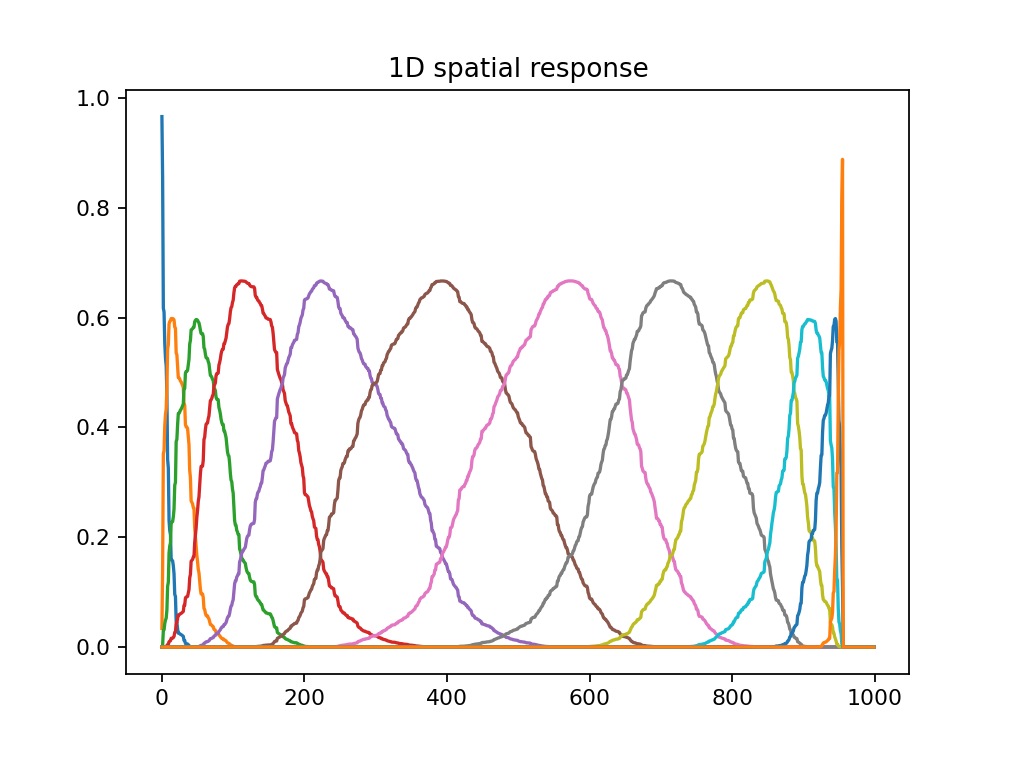

Size of X_1D (1000, 12)
Size of X_2D (1000, 144)


In [6]:
# generate three covariate
x = np.random.normal(size=tot_tp)
y = np.random.normal(size=tot_tp)
z = np.random.normal(size=tot_tp)

# add the 1d spatial variable
int_knots = np.linspace(-2,2,10)
order = 4
knots = np.hstack(([int_knots[0]]*(order-1), int_knots, [int_knots[-1]]*(order-1)))

# remove out of range values
x[np.abs(x)>2] = np.nan
y[np.abs(y)>2] = np.nan
z[np.abs(z)>2] = np.nan

# add the variable
if 'spatial_1D' in sm_handler.smooths_var:
    sm_handler.smooths_var.remove('spatial_1D')
    sm_handler.smooths_dict.pop('spatial_1D')
    
sm_handler.add_smooth('spatial_1D', [x], knots=[knots], ord=order, is_temporal_kernel=False,
                     trial_idx=trial_ids, is_cyclic=[False])


# retrive the b-spline evaluated at x.
X_1D = sm_handler['spatial_1D'].X.toarray()


# sort for plotting
plt.figure()
plt.title('1D spatial response')
idx_srt = np.argsort(x)
X_srt = X_1D[idx_srt]
p = plt.plot(X_srt)

# add a 2D response with one cyclic variable and one acyclic
if 'spatial_2D' in sm_handler.smooths_var:
    sm_handler.smooths_var.remove('spatial_2D')
    sm_handler.smooths_dict.pop('spatial_2D')

sm_handler.add_smooth('spatial_2D', [y,z], knots=[knots, knots], ord=order, is_temporal_kernel=False,
                     trial_idx=trial_ids, is_cyclic=[False,True])
X_2D = sm_handler['spatial_2D'].X.toarray()


# the size of basis set grows as n^m where n is the basis in the 1D case, and m is the number of dimensions
print('Size of X_1D',X_1D.shape)
print('Size of X_2D',X_2D.shape)

# 3. Smoothing enforcing regularization 
In order to fit the PGAM model we need to create a *smooth_handler* object with all the model covariates. As imput to the *smooths_handler* class we can specify the type of regularization that we want to enforce over the response function.

In the context of the PGAM, this will consist in a penalization of the "energy" or "wigglieness" of the response function. For any resonse function of $\text{order} \ge 4$, the most common choice is penalizeing the integral of the squared second derivative of the response,

\begin{equation}
    \mathcal{L}_j (\lambda) = \lambda \int_{D} f''(x)^2 dx,
\end{equation}

where $D$ is the domanin of the variable $x$. 

Other opitons that do not requruire the respoonse to be twice differentiable (as for and 2 splines) are available. These type of penalties are based on appropriate differences of the coefficient of the splines that very roughly approximates the second derivative squared.

The $j$-th covariate will have an assocate $\lambda_j$ that controls how much wigglieness is allowed. The larger the $\lambda_j$ the smoother the response function will be. These parameters will be larned from the data by maximizing a cross-validation objective function (the Generalized Cross Valiadtion score).

**Additional penalization terms**. Both second derivative based penalization will not penalize straight lines (second derivative =0); this means that even for extremely large $\lambda_j$ the response function would not be forced to $f=0$, but instead it will live in the space of streight lines. To avoid that, we explicitly penalized streight lines with an additional term that operates othogonally to the wiggliness penalization.



Numerical integral: 482.926068
Tikhonov regularization: 482.926068


<IPython.core.display.Javascript object>


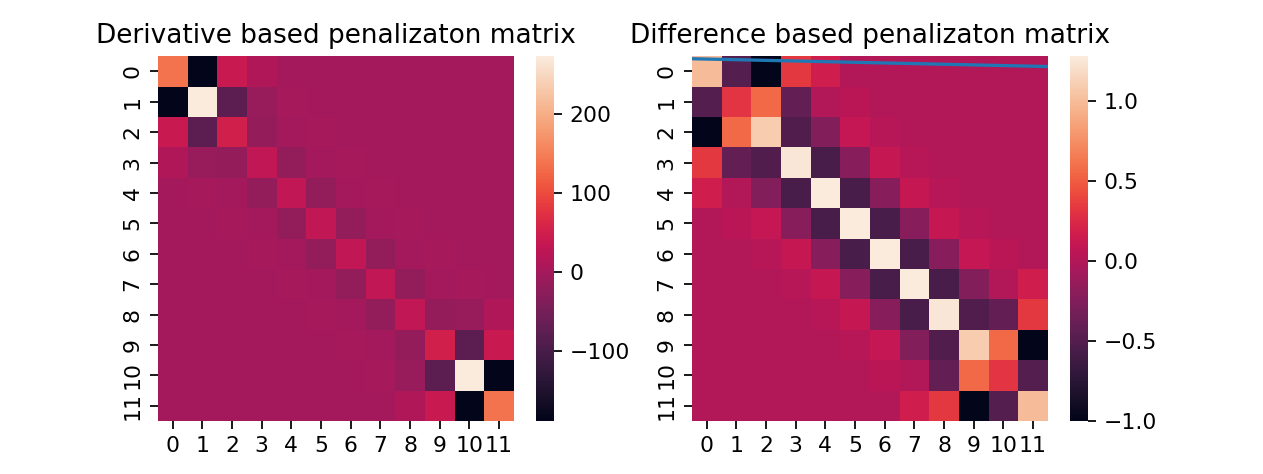


The line-penalizing term regularizes the null-space of the wigglieness penalization matrix
<P_der, u> = 0.000000


In [29]:
from scipy.integrate import simps
import seaborn as sbs

# Deriative base vs difference base penalty
sm_handler = smooths_handler()


# Set "penalty_type" to 'der' for a derivative based penalty. Set to two the order of the derivative 
# with the parameter der=2 for a second derivative based penalty
sm_handler.add_smooth('der_pen', [x], knots=[knots], ord=order, is_temporal_kernel=False,
                     trial_idx=trial_ids, is_cyclic=[False],penalty_type='der', der=2)


# Set "penalty_type" to 'diff' for a derivative based penalty. 
sm_handler.add_smooth('diff', [y], knots=[knots], ord=order, is_temporal_kernel=False,
                     trial_idx=trial_ids, is_cyclic=[False],penalty_type='diff')

# The penalization will take the form of a Tikhonov regularization over the parameters $\beta$ describing the
# response, the Tikhonov matrices can be retrived from the smooths_handler
P_der = sm_handler['der_pen'].S_list[0]
P_diff = sm_handler['diff'].S_list[0]

# set some random parameters for the response function
beta = np.random.normal(size=P_der.shape[0])

# We calculate the numerical integral of the square of the response function second derivative and
# show that the integral can be decribed as a Tkhonov regularization factor over the parameters with matrix P_der
func = lambda x : np.dot(gdh.splineDesign(knots, x, order, der=2),beta)**2
x_int = np.linspace(-2,2,10000)
num_integr = simps(func(x_int), x=x_int)
tik_pen = np.dot(np.dot(beta, P_der),beta)
print('Numerical integral: %f\nTikhonov regularization: %f'%(num_integr,tik_pen))

plt.figure(figsize=(8,3))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.set_title('Derivative based penalizaton matrix')
ax2.set_title('Difference based penalizaton matrix')
sbs.heatmap(P_der,ax=ax1)
sbs.heatmap(P_diff,ax=ax2)

# an additonal term (of dim 1),  penalizes the null space of the Tikhonov matrix, 
# which is the space of streight lines.
P_ort = sm_handler['der_pen'].S_list[1]
eig,u = np.linalg.eigh(P_ort) # only a single non-null eig (1 dim penalization)
u = u[:,np.argmax(eig)]
print('\nThe line-penalizing term regularizes the null-space of the wigglieness penalization matrix')
print('<P_der, u> = %f'%np.linalg.norm(np.dot(P_der,u)))


# 4. PGAM fit and post-processing

Putting all the pieces togheter, here we will create a *smooths_handler* object containing the appropriate covariates, fit the model, evaluate the fit quality and save the post-processed outputs in a standard numpy structured array or as a MATLAB structure.

We provide an example where spike counts are generated according to the PGAM assumptions, and estimate the response function within the GAM framework.

## 4.1 Generate synthetic data

In [2]:
## inputs parameters
num_events = 6000
time_points = 3 * 10 ** 5  # 30 mins at 0.006 ms resolution
rate = 5. * 0.006  # Hz rate of the final kernel
variance = 5.  # spatial input and nuisance variance
int_knots_num = 20  # num of internal knots for the spline basis
order = 4  # spline order

## assume 200 trials
trial_ids = np.repeat(np.arange(200),time_points//200)

## create temporal input
idx = np.random.choice(np.arange(time_points), num_events, replace=False)
events = np.zeros(time_points)
events[idx] = 1

rv = sts.multivariate_normal(mean=[0, 0], cov= variance * np.eye(2))
samp = rv.rvs(time_points)
spatial_var = samp[:, 0]
nuisance_var = samp[:, 1]

# truncate X to avoid jumps in the resp function
sele_idx = np.abs(spatial_var) < 5
spatial_var = spatial_var[sele_idx]
nuisance_var = nuisance_var[sele_idx]
while spatial_var.shape[0] < time_points:
    tmpX = rv.rvs(10 ** 4)
    sele_idx = np.abs(tmpX[:, 0]) < 5
    tmpX = tmpX[sele_idx, :]

    spatial_var = np.hstack((spatial_var, tmpX[:, 0]))
    nuisance_var = np.hstack((nuisance_var, tmpX[:, 1]))
spatial_var = spatial_var[:time_points]
nuisance_var = nuisance_var[:time_points]

# create a resp function
knots = np.hstack(([-5]*3, np.linspace(-5,5,8),[5]*3))
beta = np.arange(10)
beta = beta / np.linalg.norm(beta)
beta = np.hstack((beta[5:], beta[:5][::-1]))
resp_func = lambda x : np.dot(gdh.splineDesign(knots, x, order, der=0),beta)

filter_used_conv = sts.gamma.pdf(np.linspace(0,20,100),a=2) - sts.gamma.pdf(np.linspace(0,20,100),a=5)
filter_used_conv = np.hstack((np.zeros(101),filter_used_conv))*2
# mean of the spike counts depending on spatial_var and events
log_mu0 = resp_func(spatial_var)
for tr in np.unique(trial_ids):
    log_mu0[trial_ids == tr] = log_mu0[trial_ids == tr] + np.convolve(events[trial_ids == tr], filter_used_conv, mode='same')

# adjust mean rate
const = np.log(np.mean(np.exp(log_mu0)) / rate)
log_mu0 = log_mu0 - const

# generate spikes
spk_counts = np.random.poisson(np.exp(log_mu0))

## 4.2 Create the *smooths_handler* object and fit the model

In [3]:
import statsmodels.api as sm

sm_handler = smooths_handler()
knots = np.hstack(([-5]*3, np.linspace(-5,5,15),[5]*3))
sm_handler.add_smooth('spatial', [spatial_var], knots=[knots], ord=4, is_temporal_kernel=False,
                     trial_idx=trial_ids, is_cyclic=[False],penalty_type='der', der=2)

sm_handler.add_smooth('nuisance', [nuisance_var], knots=[knots], ord=4, is_temporal_kernel=False,
                     trial_idx=trial_ids, is_cyclic=[False],penalty_type='der', der=2)

sm_handler.add_smooth('temporal', [events], knots=None, ord=4, is_temporal_kernel=True,
                     trial_idx=trial_ids, is_cyclic=[False],penalty_type='der', der=2,
                     knots_num=10, kernel_length=500, kernel_direction=1)


# split trial in train and eval
train_trials = trial_ids % 10 != 0
eval_trials = ~train_trials


link = sm.genmod.families.links.log()
poissFam = sm.genmod.families.family.Poisson(link=link)

# create the pgam model
pgam = general_additive_model(sm_handler,
                              sm_handler.smooths_var, # list of coovarate we want to include in the model
                              spk_counts, # vector of spike counts
                              poissFam # poisson family with exponential link from statsmodels.api
                             )

# with with all covariate, remove according to stat testing, and then refit
full, reduced = pgam.fit_full_and_reduced(sm_handler.smooths_var, 
                                          th_pval=0.001,# pval for significance of covariate icluseioon
                                          max_iter=10 ** 2, # max number of iteration
                                          use_dgcv=True, # learn the smoothing penalties by dgcv
                                          trial_num_vec=trial_ids,
                                          filter_trials=train_trials)

## 4.3 Post process the results and save
After a fit, it is possible to post-process the model fit output classes to obtain a easy to parse output in the form of a numpy.structarray. 

Each row will represent results for a specific input variable, additional information about the neuron (e.g. channel ID, electrode ID, or anything else) can be provided in the form of a dictionary, each dictionary value will be stored in the structured array with type "object".

The output structure can be saved either as a ".npy" via *numpy.save(\<filename\>)* or as a MATLAB via *scipy.io.savemat(\<filename*\>)*.

Below an example of the post-processing applied to the fit just obtained.

hstack: 0.416969734000304 sec
hstack: 0.2675905510004668 sec



Result structarray types

neuron_id: 	 <class 'numpy.str_'>
fr: 	 <class 'numpy.float64'>
full_pseudo_r2_train: 	 <class 'numpy.float64'>
full_pseudo_r2_eval: 	 <class 'numpy.float64'>
reduced_pseudo_r2_train: 	 <class 'numpy.float64'>
reduced_pseudo_r2_eval: 	 <class 'numpy.float64'>
variable: 	 <class 'numpy.str_'>
pval: 	 <class 'numpy.float64'>
reduced_pval: 	 <class 'numpy.float64'>
mutual_info: 	 <class 'numpy.float64'>
x_rate_Hz: 	 <class 'numpy.ndarray'>
model_rate_Hz: 	 <class 'numpy.ndarray'>
raw_rate_Hz: 	 <class 'numpy.ndarray'>
reduced_x_rate_Hz: 	 <class 'numpy.ndarray'>
reduced_model_rate_Hz: 	 <class 'numpy.ndarray'>
reduced_raw_rate_Hz: 	 <class 'numpy.ndarray'>
eval_x_rate_Hz: 	 <class 'numpy.ndarray'>
eval_model_rate_Hz: 	 <class 'numpy.ndarray'>
eval_raw_rate_Hz: 	 <class 'numpy.ndarray'>
eval_reduced_x_rate_Hz: 	 <class 'numpy.ndarray'>
eval_reduced_model_rate_Hz: 	 <class 'numpy.ndarray'>
eval_reduced

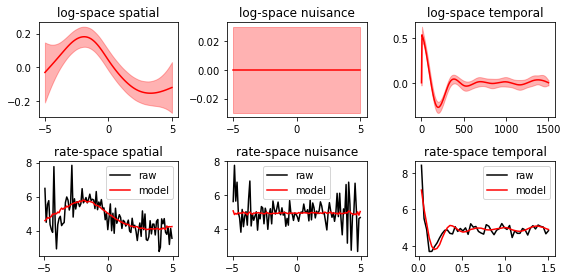

In [5]:
# string with the neuron identifier
neuron_id = 'neuron_000_sessoin_1_monkey_001'
# dictionary containing some information about the neuron, keys must be strings and values can be anything
# since are stored with type object.
info_save = {'x':100,
             'y':801.2,
             'z':301,
             'brain_region': 'V1',
             'subject':'monkey_001'
            }

# assume that we used 90% of the trials for training, 10% for evaluation
res = postprocess_results(neuron_id, spk_counts, full, reduced, train_trials,
                        sm_handler, poissFam, trial_ids, var_zscore_par=None,info_save=info_save,bins=100)

# each row of res contains the info about a variable
# some info are shared for all the variables (p-rsquared for example is a goodness of fit measure for the model
# it is shared, not a property of the variable), while other, like the parameters of the b-splines, 
# are variable specific
print('\n\n')
print('Result structarray types\n========================\n')
for name in res.dtype.names:
    print('%s: \t %s'%(name, type(res[name][0])))


# plot tuning functions
plt.figure(figsize=(8,4))

for k in range(3):
    plt.subplot(2,3,k+1)
    plt.title('log-space %s'%res['variable'][k])
    x_kernel = res['x_kernel'][k]
    y_kernel = res['y_kernel'][k]
    ypCI_kernel = res['y_kernel_pCI'][k]
    ymCI_kernel = res['y_kernel_mCI'][k]
    
    plt.plot(x_kernel, y_kernel, color='r')
    plt.fill_between(x_kernel, ymCI_kernel, ypCI_kernel, color='r', alpha=0.3)
    
    
    
    x_firing = res['x_rate_Hz'][k]
    y_firing_model = res['model_rate_Hz'][k]
    y_firing_raw = res['raw_rate_Hz'][k]
    
    plt.subplot(2,3,k+4)
    plt.title('rate-space %s'%res['variable'][k])
    
    plt.plot(x_firing, y_firing_raw, color='k',label='raw')
    plt.plot(x_firing, y_firing_model, color='r',label='model')
    
    plt.legend()
plt.tight_layout()
    

# Create and save an example configuration file



Below the code for an exaple configuration file.

In [13]:
import yaml
# Create a JSON cofiguration file and save
# var_1 will be spatial, var_2 will be temporal
order = 4
knots = np.hstack(([-2]*(order-1),np.linspace(-2,2,11),[2]*(order-1)))

# convert to float (instead np.float64, produce a yaml human readable yaml list, not needed)
knots = [float(k) for k in knots]

cov_dict = {
    'var_1' : {
        'lam':10, 
        'penalty_type': 'der', 
        'der': 2, 
        'knots': knots,
        'order':order,
        'is_temporal_kernel': False,
        'is_cyclic': [False],
        'knots_num': np.nan,
        'kernel_length': np.nan,
        'kernel_direction': np.nan,
        'samp_period':0.006 
    },
    'var_2' : {
        'lam':10,
        'penalty_type':'der',
        'der':2,
        'knots': np.nan,
        'order':order,
        'is_temporal_kernel': True,
        'is_cyclic': [False],
        'knots_num': 8,
        'kernel_length': 201,
        'kernel_direction': 0,
        'samp_period':0.006 
    },
    'spike_history':
    {
        'lam':10,
        'penalty_type':'der',
        'der':2,
        'knots': np.nan,
        'order':order,
        'is_temporal_kernel': True,
        'is_cyclic': [False],
        'knots_num': 8,
        'kernel_length': 201,
        'kernel_direction': 1,
        'samp_period':0.006 
    }
}

with open('config_pgam.yml', 'w') as outfile:
    yaml.dump(cov_dict, outfile, default_flow_style=False)
  

<class 'float'>


In [17]:

#Read the config file, the data and fit the model
with open("config_pgam.yml", "r") as stream:
    try:
        cov_dict = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
